**Demo: House Price Feature Selection with LASSO**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Downloading and cleaning data

In [2]:
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/housing_train.csv'
fn_dst = 'housing_train.csv'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File housing_train.csv is already downloaded


In [3]:
df = pd.read_csv('housing_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1460
Number attributes per sample = 81


Removing columns with missing values

In [5]:
df = df.dropna(axis=1)

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1460
Number attributes per sample = 62


Entries with "SaleCondition" not normal are removed to make regression easier

In [6]:
df = df.loc[df['SaleCondition'] == 'Normal']

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1198
Number attributes per sample = 62


One hot coding the categorical variables

In [7]:
print(df.dtypes)

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
                  ...  
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
SalePrice         int64
Length: 62, dtype: object


In [8]:
ignore_vars = ['Id', 'MoSold', 'SalePrice']
cols = df.columns
cat_vars = []
real_vars = []

for col in cols:
    
    if not (col in ignore_vars):
        if df.dtypes[col]  == 'object':
            cat_vars.append(col)
        else:
            real_vars.append(col)
                
print('Categorical variables = ' + str(cat_vars))
print('')
print('Real variables = ' + str(real_vars))

Categorical variables = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Real variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']


In [9]:
df_real = df[real_vars]
df_cat = df[cat_vars]

# One-hot encode the categorical variables
df_cat_enc = pd.get_dummies(df_cat, drop_first=True)

In [10]:
df_enc = pd.concat((df_real, df_cat_enc), axis=1)
X = np.array(df_enc)
print(X.shape)

xnames = df_enc.columns

(1198, 174)


In [11]:
y = np.array(df['SalePrice'])

Scaling the data

In [12]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)

In [13]:
from sklearn.preprocessing import StandardScaler

# Create the scaler objects
xscal = StandardScaler()
yscal = StandardScaler()

# Fit and transform the training data
Xtr1 = xscal.fit_transform(Xtr)
ytr1 = yscal.fit_transform(ytr[:,None])

# Transform the test data
Xts1 = xscal.transform(Xts)
yts1 = yscal.transform(yts[:,None])

**Linear Regression without Regularization**

In [14]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

# Fit
reg_ls = LinearRegression()
reg_ls.fit(Xtr1, ytr1)

# Training R^2
yhat1_tr = reg_ls.predict(Xtr1)
rsq_tr = r2_score(yhat1_tr, ytr1)
print('Training R^2 = %12.4e' % rsq_tr)

# Test R^2
yhat1_ts = reg_ls.predict(Xts1)
rsq_ts = r2_score(yts1, yhat1_ts)
print('Test R^2     = %12.4e' % rsq_ts)

Training R^2 =   9.3966e-01
Test R^2     =  -3.4567e+22


Using ridge regression for a better fit

In [15]:
reg_ls = Ridge(alpha=1e-5)
reg_ls.fit(Xtr1, ytr1)
yhat1 = reg_ls.predict(Xts1)
rsq = r2_score(yts1, yhat1)
print('Test R^2     = %f' % rsq)

Test R^2     = 0.887131


Plotting the actual v/s predicted values

Text(0, 0.5, 'Actual')

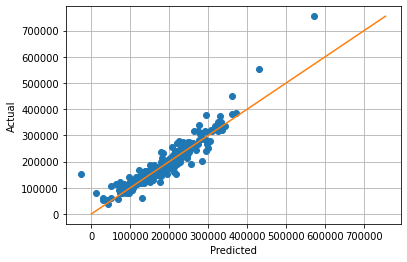

In [16]:
yhat = yscal.inverse_transform(yhat1)

yline = np.array([0, np.max(yts)])
plt.plot(yhat, yts, 'o')
plt.plot(yline, yline)
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')

Listing the variables with largest 10 coefficients

In [17]:
coeff_ls = reg_ls.coef_.ravel()
nprint = 10
I = np.argsort(np.abs(coeff_ls))
I = np.flipud(I)
for i in range(nprint):
    j = I[i]
    print('%20s %f' % (xnames[j], coeff_ls[j]) )

         MSZoning_RL 0.339747
           GrLivArea 0.278911
         MSZoning_RM 0.258912
            2ndFlrSF 0.234154
      KitchenQual_TA -0.204069
      KitchenQual_Gd -0.192469
           YearBuilt 0.191706
     RoofStyle_Gable 0.191623
       RoofStyle_Hip 0.181819
         OverallQual 0.161282


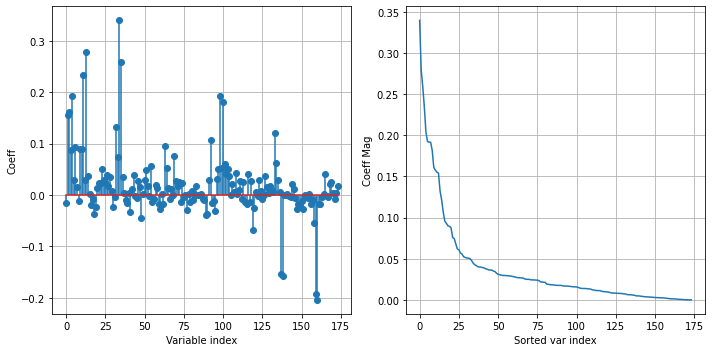

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_ls, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_ls = np.flipud(np.sort(np.abs(coeff_ls)))
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.tight_layout()

Retraining model with the top 50 parameters

In [19]:
xnames2 = []

nprint = 50
I = np.argsort(np.abs(coeff_ls))
I = np.flipud(I)
for i in range(nprint):
    j = I[i]
    temp = xnames[j]
    xnames2.append(temp)

new_df = df_enc[xnames2]

In [20]:
Xnew = np.array(new_df)

Xtr_new, Xts_new, ytr_new, yts_new = train_test_split(Xnew,y,test_size=0.3)

In [21]:
xscal = StandardScaler()
yscal = StandardScaler()

# Fit and transform the training data
Xtr1 = xscal.fit_transform(Xtr_new)
ytr1 = yscal.fit_transform(ytr_new[:,None])

# Transform the test data
Xts1 = xscal.transform(Xts_new)
yts1 = yscal.transform(yts_new[:,None])

In [22]:
reg_ls = Ridge(alpha=1e-5)
reg_ls.fit(Xtr1, ytr1)
yhat1 = reg_ls.predict(Xts1)
rsq = r2_score(yts1, yhat1)
print('Test R^2     = %f' % rsq)

Test R^2     = 0.921555


**LASSO Regression**

Minimizing objective of the form,

betahat = argmin (1/2/n)*\| y - A.dot(beta) \|^2 + alpha * \| beta \|_1

In [23]:
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Select alpha
alpha = 3e-3

# Create Lasso object and fit on training data
reg = Lasso(alpha=alpha)
reg.fit(Xtr1, ytr1)

# Predict and score on test
yhat1 = reg.predict(Xts1)
rsq = r2_score(yts1, yhat1)

print('Test R^2= %f' % rsq)

Test R^2= 0.914195


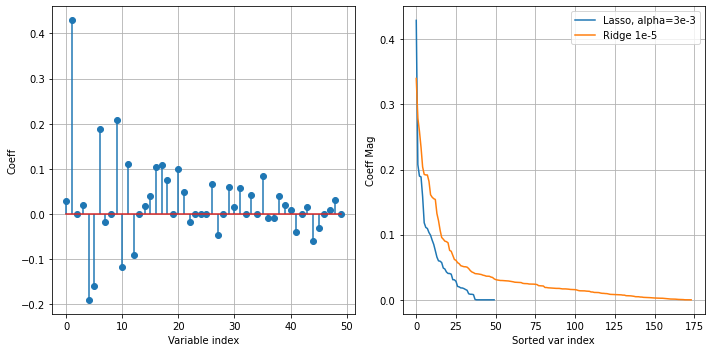

In [24]:
coeff_lasso = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_lasso = np.flipud(np.sort(np.abs(coeff_lasso)))
plt.plot(coeff_sort_lasso)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, alpha=3e-3', 'Ridge 1e-5'])
plt.tight_layout()

In [25]:
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

# Alpha values to test
alphas = np.logspace(-6,-1,40)
nalpha = len(alphas)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = y[Itr]
    Xts = X[Its,:]
    yts = y[Its]
    
    # Fit and transform the data
    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)
    ytr1 = yscal.fit_transform(ytr[:,None])
    yts1 = yscal.transform(yts[:,None])

    for i, alpha in enumerate(alphas):

        # Fit on the training data
        reg = Lasso(alpha=alpha)
        reg.fit(Xtr1, ytr1)

        # Score on the test data
        yhat1 = reg.predict(Xts1)
        rsq[i, ifold] = r2_score(yts1, yhat1)
    
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_lasso_mean = np.mean(rsq, axis=1)
rsq_lasso_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


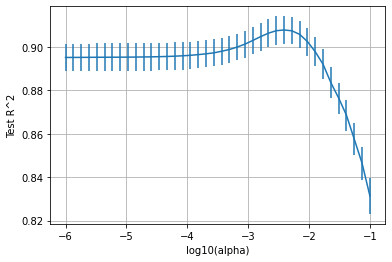

In [26]:
plt.errorbar(np.log10(alphas), rsq_lasso_mean, yerr=rsq_lasso_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.show()

In [27]:
im = np.argmax(rsq_lasso_mean)
alpha_normal = alphas[im]
print('Alpha optimal (normal rule) = %12.4e' % alpha_normal)
print('Mean test R^2 (normal rule) = %7.3f' % rsq_lasso_mean[im])

Alpha optimal (normal rule) =   3.8882e-03
Mean test R^2 (normal rule) =   0.908


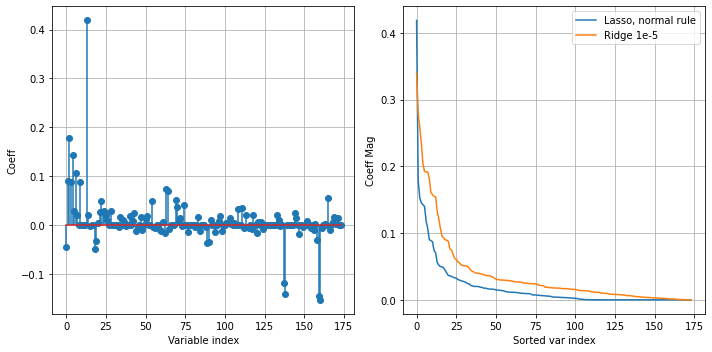

In [28]:
reg = Lasso(alpha=alpha_normal)
reg.fit(Xtr1, ytr1)

# Plot the normalized coefficients
coeff_lasso_norm = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso_norm, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_norm = np.flipud(np.sort(np.abs(coeff_lasso_norm)))
plt.plot(coeff_sort_norm)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, normal rule', 'Ridge 1e-5'])
plt.tight_layout()

Getting sparse solution using SE rule

In [29]:
im = np.argmax(rsq_lasso_mean)
rsq_tgt = rsq_lasso_mean[im] - rsq_lasso_se[im]

# Find the least complex model with R^2 > rsq_tgt
I = np.where(rsq_lasso_mean >= rsq_tgt)[0]
iopt = I[-1]
alpha_onese = alphas[iopt]

print('Alpha optimal (one SE rule) = %12.4e' % alpha_onese)
print('Mean test R^2 (one SE rule) = %7.3f' % rsq_lasso_mean[iopt])

Alpha optimal (one SE rule) =   9.4267e-03
Mean test R^2 (one SE rule) =   0.902


Optimal alpha = 0.009427


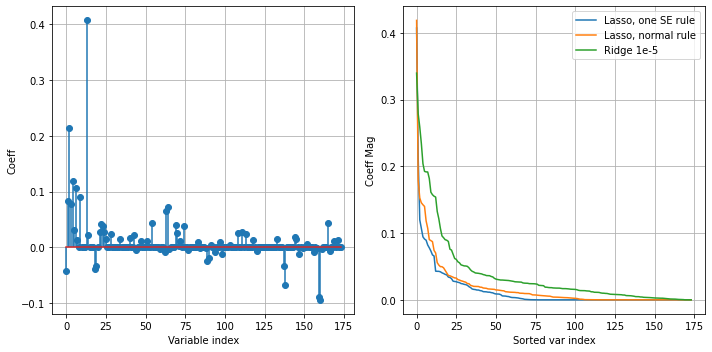

In [30]:
reg = Lasso(alpha=alpha_onese)
reg.fit(Xtr1, ytr1)

# Plot the normalized coefficients
coeff_lasso_onese = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso_onese, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_onese = np.flipud(np.sort(np.abs(coeff_lasso_onese)))
plt.plot(coeff_sort_onese)
plt.plot(coeff_sort_norm)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, one SE rule', 'Lasso, normal rule', 'Ridge 1e-5'])
plt.tight_layout()

print("Optimal alpha = %f" % alpha_onese)

In [31]:
Ils = np.argsort(np.abs(coeff_ls))
Ils = np.flipud(Ils)

Ilasso = np.argsort(np.abs(coeff_lasso_onese))
Ilasso = np.flipud(Ilasso)

nprint = 10
print('Ridge                        | Lasso')
print('-----------------------------|--------------------------------')
for i in range(nprint):
    jls = Ils[i]
    jlasso = Ilasso[i]
    print('%20s %7.2f |  %20s %7.2f' % (xnames[jls], coeff_ls[jls], xnames[jlasso], coeff_lasso_onese[jlasso]) )

Ridge                        | Lasso
-----------------------------|--------------------------------
         MSZoning_RL    0.34 |             GrLivArea    0.41
           GrLivArea    0.28 |           OverallQual    0.21
         MSZoning_RM    0.26 |             YearBuilt    0.12
            2ndFlrSF    0.23 |            BsmtFinSF1    0.11
      KitchenQual_TA   -0.20 |        KitchenQual_TA   -0.09
      KitchenQual_Gd   -0.19 |           TotalBsmtSF    0.09
           YearBuilt    0.19 |        KitchenQual_Gd   -0.09
     RoofStyle_Gable    0.19 |               LotArea    0.08
       RoofStyle_Hip    0.18 |           OverallCond    0.08
         OverallQual    0.16 |  Neighborhood_NridgHt    0.07


Getting the LASSO Path

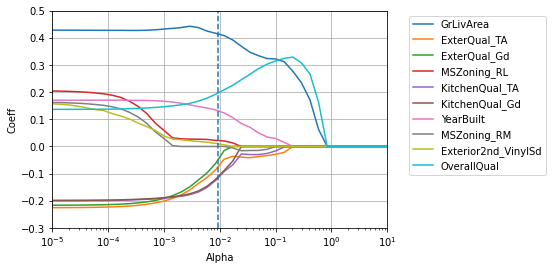

In [32]:
import sklearn.linear_model

X1 = xscal.fit_transform(X)
y1 = xscal.fit_transform(y[:,None])

alphas_path = np.logspace(-5,1,40)
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X1, y1, alphas=alphas_path)

nplot = 10
I = np.argsort(np.abs(coeffs[0,:,-1]))
I = np.flipud(I)
I = I[:nplot]

# Plot the paths of the coefficients
coeff_top = coeffs[0,I,:].T
plt.semilogx(alphas1,coeff_top)
plt.plot(alpha_onese*np.array([1,1]), [-0.3,0.5], '--')
plt.grid()
plt.legend(xnames[I], bbox_to_anchor=(1.05, 1))
plt.xlabel('Alpha')
plt.ylabel('Coeff')
plt.xlim([1e-5, 10])
_ = plt.ylim([-0.3, 0.5])